# Assignment 7: Clustering and Logistic Regression

In [1]:
import os
import string

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.target import FeatureCorrelation

sns.set_context("talk")

In [2]:
# Background Information

# The United States Census Bureau leads the country’s Federal Statistical System; its primary responsibility is to collect data upon the American people and economy to help inform strategic initiatives. Every ten years, the census is conducted to mine information regarding the US population in order to inform the allocation of billions of dollars of funding to various endeavors (e.g., the building and maintaining of hospitals, schools, fire departments, transportation infrastructure, etc. Additionally, the collection of census information helps to examine the demographic characteristics of subpopulations across the country.

# The Data

# You have been provided a sample dataset from the US Census archive containing detailed, but anonymized, information for ~300,000 individuals. This archive contains three files:
# 1. census_income_train.csv (data for model training)
# 2. census_income_test.csv (data for model testing)
# 3. census_income_metadata.txt (metadata for both datasets).
columns = [
    "AAGE",
    "ACLSWKR",
    "ADTIND",
    "ADTOCC",
    "AHGA",
    "AHRSPAY",
    "AHSCOL",
    "AMARITL",
    "AMJIND",
    "AMJOCC",
    "ARACE",
    "AREORGN",
    "ASEX",
    "AUNMEM",
    "AUNTYPE",
    "AWKSTAT",
    "CAPGAIN",
    "CAPLOSS",
    "DIVVAL",
    "FEDTAX",
    "FILESTAT",
    "GRINREG",
    "GRINST",
    "HHDFMX",
    "HHDREL",
    "MARSUPWT",
    "MIGMTR1",
    "MIGMTR3",
    "MIGMTR4",
    "MIGSAME",
    "MIGSUN",
    "NOEMP",
    "PARENT",
    "PEARNVAL",
    "PEFNTVTY",
    "PEMNTVTY",
    "PENATVTY",
    "PRCITSHP",
    "PTOTVAL",
    "SEOTR",
    "TAXINC",
    "VETQVA",
    "VETYN",
    "WKSWORK",
]

census_income_train = pd.read_csv(
    "census_income_train.csv",
    header=None,
    #   names=columns
)
census_income_train["split"] = "train"

census_income_test = pd.read_csv(
    "census_income_test.csv",
    header=None,
    #  names=columns
)
census_income_test["split"] = "test"

all_census_data = pd.concat([census_income_train, census_income_test])

In [3]:
all_census_data

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,split
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,train
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,train
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,train
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.,test
99758,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,test
99759,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.,test
99760,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,test


# Data Cleaning

In [4]:
# 1. Clean the data first
# 2. Clean text values, normalize the text: remove white spaces, etc.
# 3. Inspect unique values to all variables (you can use a loop) to ensure weird values are not in the data. You may find question marks etc. as values, which you will need to deal with.
# 4. Make sure variable types are set correctly for each variable, you can use a for loop or/and create a function to do this
# 5. Check missing values, decide how to deal with missingness... it might be advisable to drop a
# variable if it is missing more than 30 percent of the data

table = str.maketrans(" ", " ", string.punctuation)
stop_words = set(stopwords.words("english"))


def clean(text):
    try:
        tokens = word_tokenize(text)
        stripped = [str(w).lower().translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        words = [w for w in words if not w in stop_words]
        if len(words) > 50:
            return " ".join(words)
        else:
            return None
    except TypeError:
        return None

In [5]:
custom_punctuation = string.punctuation
custom_punctuation = custom_punctuation.replace("-", "")
table = str.maketrans("-)", "  ", custom_punctuation)
stop_words = set(stopwords.words("english"))


def clean_text(text):
    try:
        tokens = word_tokenize(text)
        words = [w for w in tokens if not w in stop_words]
        return " ".join(words)
    except TypeError:
        return None


pandarallel.initialize()


def clean_data(df):
    df = df.copy()
    str_cols = df.select_dtypes(include=["object"]).columns
    df[str_cols] = df[str_cols].apply(lambda x: x.str.strip())
    df[str_cols] = df[str_cols].apply(lambda x: x.str.lower())
    df[str_cols] = df[str_cols].apply(lambda x: x.str.replace("not in universe", "NaN"))
    df[str_cols] = df[str_cols].apply(lambda x: x.str.translate(table))
    for col in df[str_cols]:
        df[col] = df[col].apply(lambda x: clean_text(x))
    return str_cols, df


if os.path.exists("all_census_data_cleaned.csv"):
    all_census_data_cleaned = pd.read_csv("all_census_data_cleaned.csv", index_col=0)
    str_cols = all_census_data_cleaned.columns
else:
    all_census_data.rename(columns={41: "income"}, inplace=True)
    str_cols, all_census_data_cleaned = clean_data(
        all_census_data.drop(columns=["income"])
    )
    all_census_data_cleaned["income"] = all_census_data["income"]
    all_census_data_cleaned.to_csv("all_census_data_cleaned.csv")


for col in str_cols:
    display(pd.value_counts(all_census_data_cleaned[col]).to_frame())

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,0
34,5210
35,5120
33,5090
4,5001
5,4974
...,...
85,639
86,510
87,456
88,382


,1
private,108099
self employed incorporated,17638
local government,11617
state government,6394
federal government,4330
never worked,643
without pay,240


,2
0,150967
33,25782
43,12510
4,9051
42,6987
45,6686
29,6420
37,6161
41,5815
32,5418


,3
0,150967
2,13112
26,11701
19,8184
29,7776
36,6238
34,6047
10,5489
16,5187
12,5033


,4
high school graduate,72554
children,70864
college degree,41774
bachelors degreeba ab bs,29750
7th 8th grade,12156
10th grade,11370
11th grade,10399
masters degreema ms meng med msw mba,9847
9th grade,9335
associates degree occup vocational,8048


,5
0,282397
500,1094
600,831
700,815
800,756
...,...
1343,1
2010,1
1086,1
1754,1


,6
high school,10398
college university,8520


,7
never married,129628
married civilian spouse present,126315
divorced,19160
widowed,15788
separated,5156
married spouse absent,2234
married f spouse present,1004


,8
NaN children,150967
retail trade,25782
manufacturing durable goods,13460
education,12510
manufacturing nondurable goods,10291
finance insurance real estate,9164
construction,9051
business repair services,8636
medical except hospital,6987
public administration,6788


,9
adm support including clerical,22089
professional specialty,20809
executive admin managerial,18783
service,18276
sales,17804
precision production craft repair,15872
machine operators assmblrs inspctrs,9565
handlers equip cleaners etc,6198
transportation material moving,6060
farming forestry fishing,4666


,10
white,250978
black,30539
asian pacific islander,8748
amer indian aleut eskimo,3460


,11
mexican american,12080
mexican mexicano,10929
central south american,5882
puerto rican,4895
spanish,3728
cuban,1742
na,1279
chicano,474
know,446


,12
female,155775
male,143510


,13
yes,4475


,14
job loser,3146
entrant,3043
job loser layoff,1484
job leaver,884
new entrant,643


,15
children armed forces,185459
full time schedules,61203
labor force,40221
pt non econ reasons usually ft,5057
unemployed full time,3516
pt econ reasons usually pt,1792
unemployed part time,1254
pt econ reasons usually ft,783


,16
0,288184
15024,1168
7688,894
7298,871
99999,578
...,...
4594,1
2601,1
2227,1
8530,1


,17
0,293471
1902,620
1977,576
1887,532
1602,299
...,...
1956,2
2080,2
1640,2
2519,1


,18
0,267616
100,1719
500,1536
1000,1368
200,1347
...,...
649,1
9239,1
3873,1
347,1


,19
joint 65,113481
nonfiler,112462
single,56315
head household,11183
joint one 65 one 65,5844


,20
south,7314
west,6120
midwest,5273
northeast,4027
abroad,733


,21
california,2598
utah,1597
florida,1299
north carolina,1210
abroad,936
oklahoma,922
minnesota,869
indiana,830
north dakota,725
new mexico,691


,22
child 18 never marr subfamily,93480
householder,79939
spouse householder,62350
nonfamily householder,33456
secondary individual,9278
rel 18 never marr subfamily,3449
rel 18 ever marr subfamily,2980
grandchild 18 never marr child subfamily rp,2757
grandchild 18 never marr subfamily,2150
child 18 ever marr subfamily,1529


,23
householder,113418
child 18 never married,75465
spouse householder,62366
child 18 older,21769
relative householder,14533
nonrelative householder,11478
group quarters secondary individual,187
child 18 ever married,69


,24
707.90,53
753.23,46
1362.16,43
1191.21,43
1787.34,41
...,...
2754.88,1
3359.96,1
1048.66,1
1702.69,1


,25
nonmover,123937
msa msa,15890
nonmsa nonmsa,4155
msa nonmsa,1154
nonmsa msa,910
identifiable,630
abroad msa,619
abroad nonmsa,109


,26
nonmover,123937
county,14691
different county state,4126
different region,1761
different state division,1465
abroad,733
different division region,691


,27
nonmover,123937
county,14691
different county state,4126
different state south,1448
different state west,1037
different state midwest,793
abroad,733
different state northeast,639


,28
NaN 1 year old,151881
yes,123937


,29
yes,8669


,30
0,143872
6,54839
1,34752
4,21438
3,20261
2,15161
5,8962


,31
parents present,58342
mother present,19029
father present,2827
neither parent present,2461


,32
united states,238531
mexico,15056
puerto rico,3968
italy,3331
canada,2040
germany,2004
dominican republic,1971
poland,1841
philippines,1745
cuba,1713


,33
united states,240492
mexico,14768
puerto rico,3666
italy,2761
canada,2153
germany,2058
philippines,1876
cuba,1704
poland,1695
el salvador,1642


,34
united states,265342
mexico,8703
puerto rico,2092
philippines,1299
germany,1271
cuba,1265
canada,1046
el salvador,1032
dominican republic,1017
china,715


,35
native born united states,265347
foreign born citizen u,20107
foreign born u citizen naturalization,8867
native born abroad american parents,2707
native born puerto rico u outlying,2257


,36
0,270860
2,24387
1,4038


,37
yes,590


,38
2,225427
0,70847
1,3011


,39
0,143872
52,105366
40,4152
50,3414
26,3393
48,2816
12,2733
30,2103
20,2055
8,1690


,40
94,149643
95,149642


,split
train,199523
test,99762


,income
- 50000.,280717
50000+.,18568


In [6]:
all_census_data_cleaned.apply(set)

0         {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1         {nan, without pay, state government, self empl...
2         {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3         {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
4         {less 1st grade, high school graduate, doctora...
5         {0, 20, 70, 75, 100, 8300, 110, 125, 135, 143,...
6                    {nan, college university, high school}
7         {married f spouse present, never married, marr...
8         {education, manufacturing nondurable goods, ho...
9         {nan, technicians related support, transportat...
10        {nan, white, asian pacific islander, amer indi...
11        {nan, mexican mexicano, know, mexican american...
12                                           {male, female}
13                                               {nan, yes}
14        {nan, job loser layoff, job leaver, job loser,...
15        {children armed forces, labor force, pt non ec...
16        {0, 2050, 4101, 7688, 14344, 2

In [7]:
all_census_data_cleaned["income_above_50"] = (
    all_census_data_cleaned["income"] == " 50000+."
)
all_census_data_cleaned.drop(columns=["income"], inplace=True)
all_census_data_cleaned["income_above_50"] = all_census_data_cleaned[
    "income_above_50"
].astype(int)
all_census_data_cleaned

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,split,income_above_50
0,73,NaN,0,0,high school graduate,0,NaN,widowed,NaN children,NaN,...,united states,united states,native born united states,0,NaN,2,0,95,train,0
1,58,self employed incorporated,4,34,college degree,0,NaN,divorced,construction,precision production craft repair,...,united states,united states,native born united states,0,NaN,2,52,94,train,0
2,18,NaN,0,0,10th grade,0,high school,never married,NaN children,NaN,...,vietnam,vietnam,foreign born citizen u,0,NaN,2,0,95,train,0
3,9,NaN,0,0,children,0,NaN,never married,NaN children,NaN,...,united states,united states,native born united states,0,NaN,0,0,94,train,0
4,10,NaN,0,0,children,0,NaN,never married,NaN children,NaN,...,united states,united states,native born united states,0,NaN,0,0,94,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,NaN,0,0,children,0,NaN,never married,NaN children,NaN,...,united states,united states,native born united states,0,NaN,0,0,95,test,0
99758,61,private,8,36,11th grade,0,NaN,separated,manufacturing durable goods,machine operators assmblrs inspctrs,...,united states,united states,native born united states,0,NaN,2,52,95,test,0
99759,24,self employed incorporated,1,43,7th 8th grade,0,NaN,married civilian spouse present,agriculture,farming forestry fishing,...,mexico,mexico,foreign born u citizen naturalization,0,NaN,2,52,94,test,0
99760,30,private,45,2,bachelors degreeba ab bs,0,NaN,married civilian spouse present,professional services,executive admin managerial,...,united states,united states,native born united states,0,NaN,2,52,95,test,0


In [8]:
# labelencode all string type columns
le_encoders = []
for col in all_census_data_cleaned.select_dtypes(include=["object"]).columns:
    if col == "split":
        pass
    le = LabelEncoder()
    all_census_data_cleaned[col] = le.fit_transform(all_census_data_cleaned[col])
    le_encoders.append((col, le))

In [9]:
all_census_data_cleaned["split"] = all_census_data["split"]
all_census_data_cleaned

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,split,income_above_50
0,73,7,0,0,13,0,2,6,0,14,...,39,39,4,0,1,2,0,95,train,0
1,58,4,4,34,11,0,2,0,5,6,...,39,39,4,0,1,2,52,94,train,0
2,18,7,0,0,0,0,1,4,0,14,...,40,40,0,0,1,2,0,95,train,0
3,9,7,0,0,10,0,2,4,0,14,...,39,39,4,0,1,0,0,94,train,0
4,10,7,0,0,10,0,2,4,0,14,...,39,39,4,0,1,0,0,94,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,7,0,0,10,0,2,4,0,14,...,39,39,4,0,1,0,0,95,test,0
99758,61,3,8,36,1,0,2,5,11,5,...,39,39,4,0,1,2,52,95,test,0
99759,24,4,1,43,5,0,2,1,1,3,...,25,25,1,0,1,2,52,94,test,0
99760,30,3,45,2,9,0,2,1,17,2,...,39,39,4,0,1,2,52,95,test,0


In [10]:
train_data = all_census_data_cleaned[all_census_data_cleaned["split"] == "train"].drop(
    "split", axis=1
)
test_data = all_census_data_cleaned[all_census_data_cleaned["split"] == "test"].drop(
    "split", axis=1
)

In [11]:
X_train, y_train = (
    train_data.drop(columns=["income_above_50"]),
    train_data["income_above_50"],
)
X_test, y_test = (
    test_data.drop(columns=["income_above_50"]),
    test_data["income_above_50"],
)

In [12]:
models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    xgb.XGBClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        use_label_encoder=False,
        eval_metric="auc",
    ),
]

data = [
    ("Train", X_train, y_train),
    ("Test", X_test, y_test),
]

results = []

for model in models:
    model_name = model.__class__.__name__
    if model_name == "LogisticRegression":
        model = Pipeline(
            [
                ("standardization", StandardScaler()),
                (model_name, model),
            ]
        )
    model.fit(X_train, y_train)

    print(model_name)

    for dat_name, x_dat, y_dat in data:

        print(dat_name, "Data Results:")

        results.append(
            [
                (
                    model_name,
                    "without_pca",
                    "score",
                    dat_name,
                    model.score(x_dat, y_dat),
                )
            ]
        )

        print(classification_report(y_dat, model.predict(x_dat)))

    print("-" * 50)

/Users/raja_/Documents/GitHub/msds_winter_2022/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
Train Data Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    187141
           1       0.72      0.28      0.40     12382

    accuracy                           0.95    199523
   macro avg       0.84      0.64      0.69    199523
weighted avg       0.94      0.95      0.94    199523

Test Data Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     93576
           1       0.72      0.28      0.40      6186

    accuracy                           0.95     99762
   macro avg       0.84      0.64      0.69     99762
weighted avg       0.94      0.95      0.94     99762

--------------------------------------------------
RandomForestClassifier
Train Data Results:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    187141
           1       0.87      0.31      0.45     12382

    accuracy                  

In [13]:
results_df = pd.DataFrame(results)
results_df = pd.DataFrame(
    results_df[0].to_list(), columns=["model", "pca", "metric", "dataset", "value"]
)
results_df

,model,pca,metric,dataset,value
0,LogisticRegression,without_pca,score,Train,0.948427
1,LogisticRegression,without_pca,score,Test,0.948608
2,RandomForestClassifier,without_pca,score,Train,0.954231
3,RandomForestClassifier,without_pca,score,Test,0.951845
4,XGBClassifier,without_pca,score,Train,0.979291
5,XGBClassifier,without_pca,score,Test,0.957439


<IPython.core.display.Javascript object>

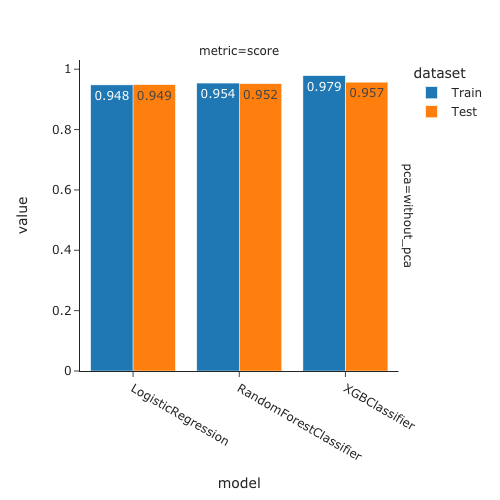

In [25]:
results_df["value"] = results_df["value"].round(3)

(
    px.bar(
        data_frame=results_df,
        x="model",
        y="value",
        color="dataset",
        facet_row="pca",
        facet_col="metric",
        text="value",
        labels="value",
        barmode="group",
        template="simple_white",
        width=500
    )
    .update_xaxes(showticklabels=True)
    .update_yaxes(showticklabels=True)
    .show(renderer="png")
)

In [14]:
X, y = (
    all_census_data_cleaned.drop(columns=["income_above_50"]),
    all_census_data_cleaned["income_above_50"],
)

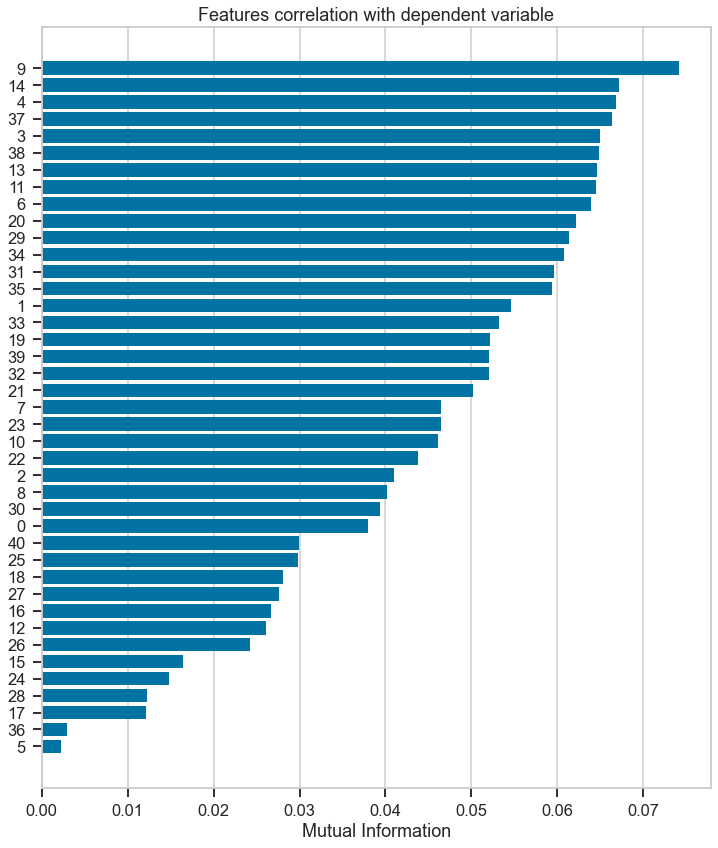

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [15]:
visualizer = FeatureCorrelation(method="mutual_info-classification", sort=True)
plt.figure(figsize=(12, 14))
visualizer.fit(X.drop("split", axis=1), y)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [16]:
all_census_data

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,split
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,train
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,train
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,train
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.,test
99758,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,test
99759,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.,test
99760,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,test


In [17]:
print(list(enumerate(columns)))

[(0, 'AAGE'), (1, 'ACLSWKR'), (2, 'ADTIND'), (3, 'ADTOCC'), (4, 'AHGA'), (5, 'AHRSPAY'), (6, 'AHSCOL'), (7, 'AMARITL'), (8, 'AMJIND'), (9, 'AMJOCC'), (10, 'ARACE'), (11, 'AREORGN'), (12, 'ASEX'), (13, 'AUNMEM'), (14, 'AUNTYPE'), (15, 'AWKSTAT'), (16, 'CAPGAIN'), (17, 'CAPLOSS'), (18, 'DIVVAL'), (19, 'FEDTAX'), (20, 'FILESTAT'), (21, 'GRINREG'), (22, 'GRINST'), (23, 'HHDFMX'), (24, 'HHDREL'), (25, 'MARSUPWT'), (26, 'MIGMTR1'), (27, 'MIGMTR3'), (28, 'MIGMTR4'), (29, 'MIGSAME'), (30, 'MIGSUN'), (31, 'NOEMP'), (32, 'PARENT'), (33, 'PEARNVAL'), (34, 'PEFNTVTY'), (35, 'PEMNTVTY'), (36, 'PENATVTY'), (37, 'PRCITSHP'), (38, 'PTOTVAL'), (39, 'SEOTR'), (40, 'TAXINC'), (41, 'VETQVA'), (42, 'VETYN'), (43, 'WKSWORK')]


In [18]:
# Apply clustering to the features only, leave out the output variable. First extract the features, use PCA to get two principal components, build clusters with the principal components, use a dendrogram to find how many clusters are needed, also use an elbow plot to see how many clusters are needed, then finally run a k-means clustering algorithm to build the final clusters with the optimal number of clusters. Cluster analysis can be used as preliminary analysis where cluster predictions are used as output data with the training features to make a complete dataset for supervised learning. Run another cluster analysis and specify two clusters, then compare the cluster predictions with the actual output (which serves as ground truth in this case) to check what percentage of the cluster predictions of the training input data match with the ground truth in the training data? Also use cluster predictions of test set and check what percentage of ground truth in test data is correctly predicted? Do you think we should use the cluster predictions to represent the output, income levels (income above 50k or income below 50k)? Why or why not?

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

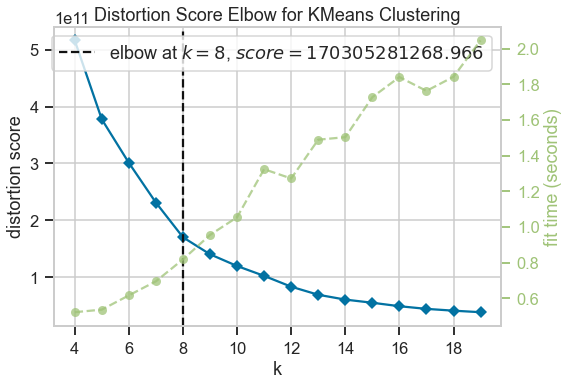

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
visualizer = KElbowVisualizer(KMeans(), k=(4, 20))
visualizer.fit(X_pca)
visualizer.show()

In [20]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X_pca)
print(classification_report(y_train, kmeans.predict(X_pca), zero_division=0))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96    187141
           1       0.88      0.03      0.05     12382
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.92    199523
   macro avg       0.23      0.13      0.13    199523
weighted avg       0.95      0.92      0.91    199523



In [21]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
print(classification_report(y_train, kmeans.predict(X_pca)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    187141
           1       0.88      0.03      0.05     12382

    accuracy                           0.94    199523
   macro avg       0.91      0.51      0.51    199523
weighted avg       0.94      0.94      0.91    199523



In [22]:
print(
    classification_report(
        y_test, kmeans.predict(pca.fit_transform(X_test)), zero_division=0
    )
)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93576
           1       0.90      0.03      0.05      6186

    accuracy                           0.94     99762
   macro avg       0.92      0.51      0.51     99762
weighted avg       0.94      0.94      0.91     99762

